# Imports

In [42]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import azureml.core

from datetime import datetime, timedelta
from azureml.core import Dataset
from azureml.opendatasets import NoaaIsdWeather

## Declare variables, read in NOAA ISD data, write to CSV
Using January 2019 weather data as the baseline and June 2019 as the test. Write the data to local csv so that they can be used in Datasets. If you've already registered Datasets with the workspace, you can replace them in the following cells.

In [43]:
# baseline dataset start and end
BASELINE_START = datetime(2019, 1, 1)
BASELINE_END   = datetime(2019, 1, 8)

# test dataset start and end
TEST_START     = datetime(2019, 7, 1)
TEST_END       = datetime(2019, 7, 8)

# names for writing datasets
local_folder   = 'simple-diff'
baseline_file  = 'baseline.csv'
test_file      = 'test.csv'

# make local dir 
os.makedirs(local_folder, exist_ok=True)

# get baseline dataset
isd_b          = NoaaIsdWeather(BASELINE_START, BASELINE_END)
baseline_df    = isd_b.to_pandas_dataframe()

# get test dataset 
isd_t          = NoaaIsdWeather(TEST_START, TEST_END)
test_df        = isd_t.to_pandas_dataframe()

# write baseline dataframe to local csv
print('writing baseline dataframe to csv...')
baseline_df.to_csv(local_folder + "/" + baseline_file)
print('Done.')
    
# write test dataframe to local csv
print('writing test dataframe to csv...')
test_df.to_csv(local_folder + "/" + test_file)
print('Done.')

ActivityStarted, to_pandas_dataframe
ActivityStarted, to_pandas_dataframe_in_worker
Target paths: ['/year=2019/month=1/']
Looking for parquet files...
Reading them into Pandas dataframe...
Reading ISDWeather/year=2019/month=1/part-00043-tid-7785455726218446485-a0ae6467-7b8d-4da5-b22e-d1f6db3024ed-1422527.c000.snappy.parquet under container isdweatherdatacontainer
Done.
ActivityCompleted: Activity=to_pandas_dataframe_in_worker, HowEnded=Success, Duration=11097.02 [ms]
ActivityCompleted: Activity=to_pandas_dataframe, HowEnded=Success, Duration=11109.3 [ms]
ActivityStarted, to_pandas_dataframe
ActivityStarted, to_pandas_dataframe_in_worker
Target paths: ['/year=2019/month=7/']
Looking for parquet files...
Reading them into Pandas dataframe...
Reading ISDWeather/year=2019/month=7/part-00107-tid-7785455726218446485-a0ae6467-7b8d-4da5-b22e-d1f6db3024ed-1422591.c000.snappy.parquet under container isdweatherdatacontainer
Done.
ActivityCompleted: Activity=to_pandas_dataframe_in_worker, HowEnded

In [44]:
#baseline_df.head()

In [45]:
#test_df.head()

# Create Azure ML Datasets 

and compute the profile of the baseline and test datasets 

In [46]:
# create Azure ML dataset from local file
baseline = Dataset.auto_read_files(local_folder + "/" + baseline_file, include_path=True)

# The baseline data is not filtered by feature columns list, thus all retrieved data columns will be listed below.
# You'll see "Column1" in the output, which is a default name added when the original column is not available.
#baseline.get_profile()

In [47]:
# create Azure ML dataset from local file 
test = Dataset.auto_read_files(local_folder + "/" + test_file, include_path=True)

# The baseline data is not filtered by feature columns list, thus all retrieved data columns will be listed below.
# You'll see "Column1" in the output, which is a default name added when the original column is not available.
#test.get_profile()

In [48]:
# exclude unneccesary (Path, version, year, day) and columns that clearly drift (datetime)
columns = ['usaf', 'wban', 'latitude', 'longitude', 'elevation', 'windAngle', 'windSpeed', 'temperature', 'seaLvlPressure', 'cloudCoverage', 'presentWeatherIndicator', 'pastWeatherIndicator', 'precipTime', 'precipDepth', 'snowDepth', 'stationName', 'countryOrRegion', 'p_k']

diff_action = baseline.diff(rhs_dataset=baseline, columns=columns)
diff_action.wait_for_completion()

result = diff_action.get_result()
#result

/home/azureuser/.local/lib/python3.6/site-packages/azureml/data/_dataset_diff.py:468: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  base[c] = base[c].fillna(value="__null__")
/home/azureuser/.local/lib/python3.6/site-packages/azureml/data/_dataset_diff.py:469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  diff[c] = diff[c].fillna(value="__null__")
/home/azureuser/.local/lib/python3.6/site-packages/azureml/data/_dataset_diff.py:472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [49]:
# overall measure of difference between baseline and test and contribution by feature
# 0: no difference
# 1: completely different
# calculated with ML two-sample test and output as 'drift coefficient'

for measurement in result:
    if measurement.name == 'datadrift_coefficient':
        print('Magnitude of drift: {}/1.0'.format(round(measurement.value, 3)))
        
feature_contrib_x = []
feature_contrib_y = []

# additionally from ML two-sample test, measure contribution of each feature to the overall magnitude 

for measurement in result:
    if measurement.name == 'datadrift_contribution':
        feature_contrib_x.append(measurement.extended_properties['column_name'])
        feature_contrib_y.append(measurement.value)

Magnitude of drift: 0.139/1.0


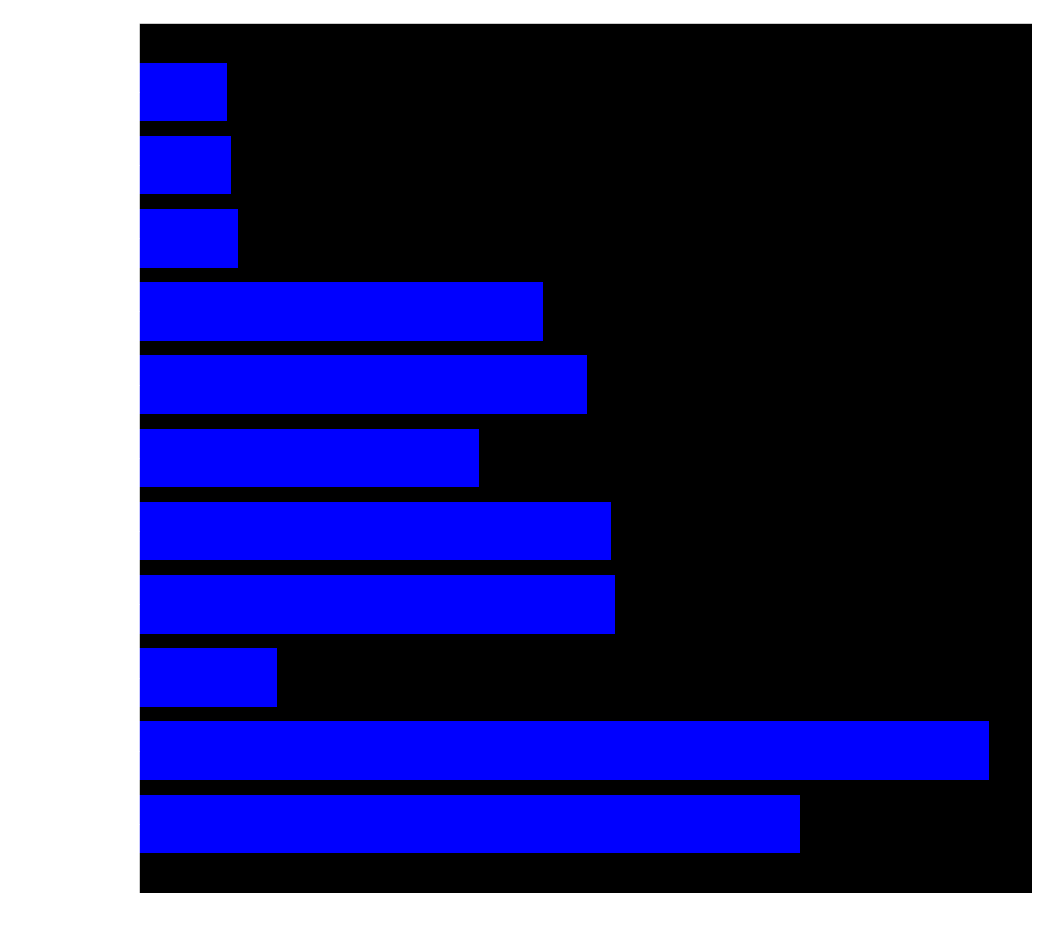

In [50]:
# plot contribution of feature to drift magnitude 

%matplotlib inline

fig = plt.figure(figsize=(16, 16))

## if using dark mode, uncomment this
#plt.style.use(['dark_background'])

plt.barh(feature_contrib_x, feature_contrib_y, color='b')
plt.yticks(feature_contrib_x)
plt.title('Contribution to Magnitude of Drift by Feature')
plt.xlabel('Contribution')
plt.show()

In [51]:
# drill down into diff measurements and statistical distances for a given column
column_name = 'latitude'

for measurement in result:
    if measurement.extended_properties['metric_category'] in ('profile_diff', 'statistical_distance') and measurement.extended_properties['column_name'] == column_name:
        print('{} : {}'.format(measurement.name, measurement.value))

percentage_difference_min : 0.0
difference_min : 0.0
percentage_difference_max : 0.0
difference_max : 0.0
percentage_difference_median : 0.0
difference_median : 0.0
percentage_difference_mean : 0.0
difference_mean : 0.0
percentage_difference_variance : 0.0
difference_variance : 0.0
percentage_difference_standard_deviation : 0.0
difference_standard_deviation : 0.0
percentage_difference_skewness : 0.0
difference_skewness : 0.0
percentage_difference_kurtosis : 0.0
difference_kurtosis : 0.0
percentage_difference_percentile_0.001 : 0.0
difference_percentile_0.001 : 0.0
percentage_difference_percentile_0.01 : 0.0
difference_percentile_0.01 : 0.0
percentage_difference_percentile_0.05 : 0.0
difference_percentile_0.05 : 0.0
percentage_difference_percentile_0.25 : 0.0
difference_percentile_0.25 : 0.0
percentage_difference_percentile_0.5 : 0.0
difference_percentile_0.5 : 0.0
percentage_difference_percentile_0.75 : 0.0
difference_percentile_0.75 : 0.0
percentage_difference_percentile_0.95 : 0.0
di

# Predefine Methods For Result Processing

## Parse and Present Datasets' Diff Results

<font size=2>Each diff result is a list of "DiffMetric" objects. Typically each objec present a detailed measurement output for a specific column.
<br><br>Below is an example of "DiffMetric" object:</font>
<font face="monospace" size=1>
<br>&nbsp;&nbsp;&nbsp;&nbsp;{&nbsp;&nbsp;
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'name':'percentage_difference_median',&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-->&nbsp;measurement&nbsp;name
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'value':0.01270670472603889,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-->&nbsp;the result value a number to indicate how big the diff is for current measurement.
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'extended_properties':{&nbsp;&nbsp;
</font><font face="monospace" size=1 color=LightSteelBlue><br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'action_id':'3d3da05d-0871-4cc9-93cb-f43859aae13b',&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-->&nbsp;(remote&nbsp;calculation&nbsp;only)&nbsp;action&nbsp;id
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'from_dataset_id':'12edc566-8803-4e0f-ba91-c2ee05eeddee',&nbsp;&nbsp;-->&nbsp;(remote&nbsp;calculation&nbsp;only)&nbsp;baseline&nbsp;dataset
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'from_dataset_version':'1',&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-->&nbsp;(remote&nbsp;calculation&nbsp;only)&nbsp;baseline&nbsp;version
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'to_dataset_id':'9b85c9ba-50c2-4227-a9bc-91dee4a18228',&nbsp;&nbsp;&nbsp;&nbsp;-->&nbsp;(remote&nbsp;calculation&nbsp;only)&nbsp;target&nbsp;dataset
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'to_dataset_version':'1',&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-->&nbsp;(remote&nbsp;calculation&nbsp;only)&nbsp;target&nbsp;version
</font><font face="monospace" size=1><br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'column_name':'elevation',&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-->&nbsp;column&nbsp;name&nbsp;in&nbsp;dataset,&nbsp;<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;could&nbsp;be&nbsp;['name':'datadrift_coefficient']&nbsp;for&nbsp;dataset&nbsp;level&nbsp;diff
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;'metric_category':'profile_diff'&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-->&nbsp;category,&nbsp;could&nbsp;be&nbsp;:<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;dataset_drift (dataset level)<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;profile_diff (column level)<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;statistical_distance (column level)
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;}
<br>&nbsp;&nbsp;&nbsp;&nbsp;}
</font>